# Forest elephant vocalisation call-type classification

This Jupyter notebook provides a step-by-step guide to using unsupervised deep learning techniques to classify forest elephant vocalisation call-types and evaluate the performance of these techniques. In this notebook, we take a datset containing three different forest elephant vocalisations and use the unsupervised techniques to automatically extract the acoustic features, project these high-dimensional features into lower dimensional space and evaluate how well these methods have been able to distinguish the call-types. 

## Dataset Description

The call-type dataset contains audio files of African forest elephants recorded by the Elephant Listening Project in the Dzanga-Bai clearing in the the southwestern Central African Republic between September 2018 and April 2019. It has 1254 rows each representing an elephant vocalisation with the start time, end time, low frequency and high frequency annotated alongside the call-type (roar, rumble or trumpet).

## Steps

The steps follow those described in the methods section of **link** with an additional step 0 introduced to import the necessary libraries. Steps 2 & 3 are combined in this notebook as this is a more computationally efficient way of processing the information. The separate functions can be viewed in the feature_extraction.py script.

0. **Set-up** Import the libraries and functions needed to conduct the analysis
1. **Vocalisation dataset**: Load the dataset and understand its structure.
2. **Audio pre-processing**: Pre-process the data to isolate the vocalisations and automatically and 
3. **Feature extraction**: extract the acoustic features using a pre-trained Convolutional Neural Network.
4. **Dimensionality reduction**: Project the acoustic features into 2D space to visualise the call-type classifications.
5. **Statistical analysis**: Perform statistical tests to evalute how well the call-types have been identified.

### 0. Set-up

Here we will import a series of pre-defined scripts used to automate the import of the libraries needed for each of the aforementioned steps. These are all located in the "elephant_scripts" folder in the main project repository.

In [1]:
# Step 0: load all of the main libraries needed for the notebook set-up
from elephant_scripts.import_libraries import * 

# Step 1: load the script for the vocalisation dataset 
from elephant_scripts.load_data import * #

# Step 2 & 3: load the functions needed for audio pre-processing and feature extraction
from elephant_scripts.feature_extraction import read_audio, apply_bandpass_filter, extract_audio, normalise_sound_file, wav_cookiecutter, feature_extraction, feature_heatmap

# Step 4: load the functions needed for dimensionality reduction
from elephant_scripts.umap_projections import *

# Step 5: load the functions to calculate and visualise silhouette scores for the statistical analysis
from elephant_scripts.silhouette_score import * 

# enable plots to be auto-displayed in the notebook
%matplotlib inline 

2023-08-10 18:02:03.199546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Main libraries successfully imported
Info file loaded: /Users/alastairpickering/Desktop/Alastair/Ecology and Data Science/Research project/elephant_analysis_repository_github/data/1.elephant_call_type_df.csv
Audio file paths added to DataFrame
Vocalisation Dataset successfully loaded
Functions for Audio Pre-processing and Feature Extraction successfully loaded
Functions for Dimensionality Reduction successfully loaded
Functions for Statistical Analysis successfully imported


### 1. Vocalisation dataset

In the set-up step we have specified the directories used for the audio and metadata files, named the label columns and associated the individual wav files with their respective rows in the metadata dataframe. We'll now view the dataframe to make sure it looks as intended.

In [2]:
# Visualise the vocalisation dataset
df

,filename,recording_id,start_time,end_time,duration,low_freq,high_freq,call-type,audio_filepaths
0,opp_328_ro.wav,683,2.928746,4.904429,1.975683,130.078125,1981.909180,Roar,/Users/alastairpickering/Desktop/Alastair/Ecol...
1,opp_329_ro.wav,77,3.430024,4.583235,1.153211,1.318359,245.214844,Rumble,/Users/alastairpickering/Desktop/Alastair/Ecol...
2,opp_329_ro.wav,76,1.615771,3.615637,1.999866,196.948242,1985.546875,Roar,/Users/alastairpickering/Desktop/Alastair/Ecol...
3,opp_330_ru.wav,226,1.628424,3.790237,2.161813,1.220703,326.464844,Rumble,/Users/alastairpickering/Desktop/Alastair/Ecol...
4,opp_331_ro.wav,376,2.656950,3.346179,0.689229,57.446289,1937.133789,Roar,/Users/alastairpickering/Desktop/Alastair/Ecol...
5,opp_332_ru.wav,137,2.229882,5.752067,3.522186,1.635742,197.631836,Rumble,/Users/alastairpickering/Desktop/Alastair/Ecol...
6,opp_333_ru.wav,642,3.098901,6.639745,3.540844,0.756836,197.167969,Rumble,/Users/alastairpickering/Desktop/Alastair/Ecol...
7,opp_365_trumpet.wav,1100,2.097081,2.565536,0.468455,33.789062,1937.377930,Trumpet,/Users/alastairpickering/Desktop/Alastair/Ecol...
8,opp_365_trumpet.wav,1101,0.018448,0.803142,0.784694,48.730469,1971.850586,Trumpet,/Users/alastairpickering/Desktop/Alastair/Ecol...
9,opp_397_trumpet.wav,654,1.879193,2.764525,0.885332,131.787109,1957.934570,Trumpet,/Users/alastairpickering/Desktop/Alastair/Ecol...


### 2. Audio pre-processing and 3. Feature extraction

Now that the dataframe is loaded and associated with the audio files, we need to pre-process the audio files to extract the exact frequency ranges and time periods associated with the vocalisations. This helps to minimise unwanted environmental sound that may cause erroneous results. These pre-processed audio files are then passed through the VGGish pre-trained CNN in 0.96s multiples and their acoustic features are automatically extracted to produce embeddings. These embeddings are then averaged to obtain a single embedding per vocalisation. These are the steps take to pre-process the files and extract their audio features:

1. Read the entire audio file.
2. Apply a bandpass filter to exclude frequencies outside the vocalisation range using the low_frequency and high_frequency information.
3. Extract the audio clip corresponding to the vocalisation using the start_time and end_time information.
4. Normalise the audio clip to have a peak amplitude of 1 to control for elephant distance from the microphone.
5. Pad the audio to a length that is a multiple of 96 (the input size of the VGGish model) and centre the recording within this padding.
6. Extract the acoustic feature embeddings for each 96-sample chunk of the audio clip using the pretrained CNN VGGish.
7. Average the embeddings across the chunks to obtain a single embedding for each vocalisation.
8. Add in information about the duration of each vocalisation

This resulting embedding encodes the acoustic feature representation of the vocalisation.

These steps are carried out using a series of functions in the combined feature_extraction.py file

In [3]:
# Pass the vocalisation dataframe through the pre-processing functions before extracting the acoustic features
results = feature_extraction(df)

2023-08-10 18:02:42.198688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Processing: 100%|███████████████████████████████| 10/10 [00:02<00:00,  4.93it/s]


Features successfully extracted
Features successfully averaged per vocalisation
Duration successfully added as the 129th feature


It can be hard to conceptualise the output of the feature extraction process. Here we can see a representation of the 129 features (x-axis) normalised on a 0-1 scale for each of the 1254 recordings (y-axis). 

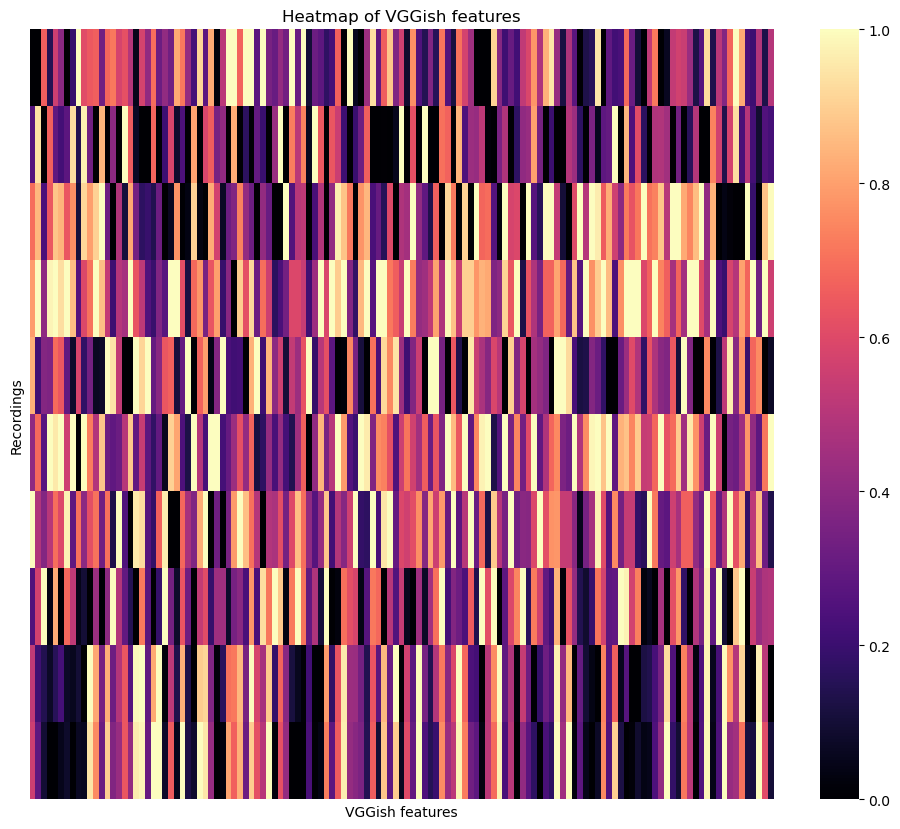

In [4]:
# Show feature heatmap of 129 acoustic features per recording
feature_heatmap(results);

In [5]:
# Save the extracted acoustic features to a csv file
results.to_csv(os.path.join(os.path.sep, DATA, 'acoustic_features.csv'))

### 4. Dimensionality reduction

Now that we have the 129D embeddings for each of the 1254 recordings we need to reduce this high-dimensional data into lower dimensional space to make it interpretable to the human brain and usable in the statistical tests. This involves 4 steps:
1. Specify the parameters for the dimensionality reduction, including the number of components (2) and distance metric we want to use (cosine)
2. Normalise the 129D embeddings so that their mean = 0 and variance = 1. This ensures equal weighting of the features
3. Carry out the dimensionality reduction
4. Visualise the results to enable observation of clustering

In [6]:
# Load the saved acoustic features
results = pd.read_csv(os.path.join(os.path.sep, DATA, 'acoustic_features.csv'))

In [7]:
# Specify the UMAP parameters
results_df = results # name of the dataframe where the embeddings are contained
metadata_df = df # name of the dataframe where the call-type labels are contained
N_COMP = 2 # select 1, 2 or 3 dimensions
metric = 'cosine' # defaults to euclidean but can specify 'cosine' or other distance metrics
min_dist = 0 # minimum distance apart that points are allowed to be in the low dimensional representation

Acoustic features normalised


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Dimensionality reduction completed


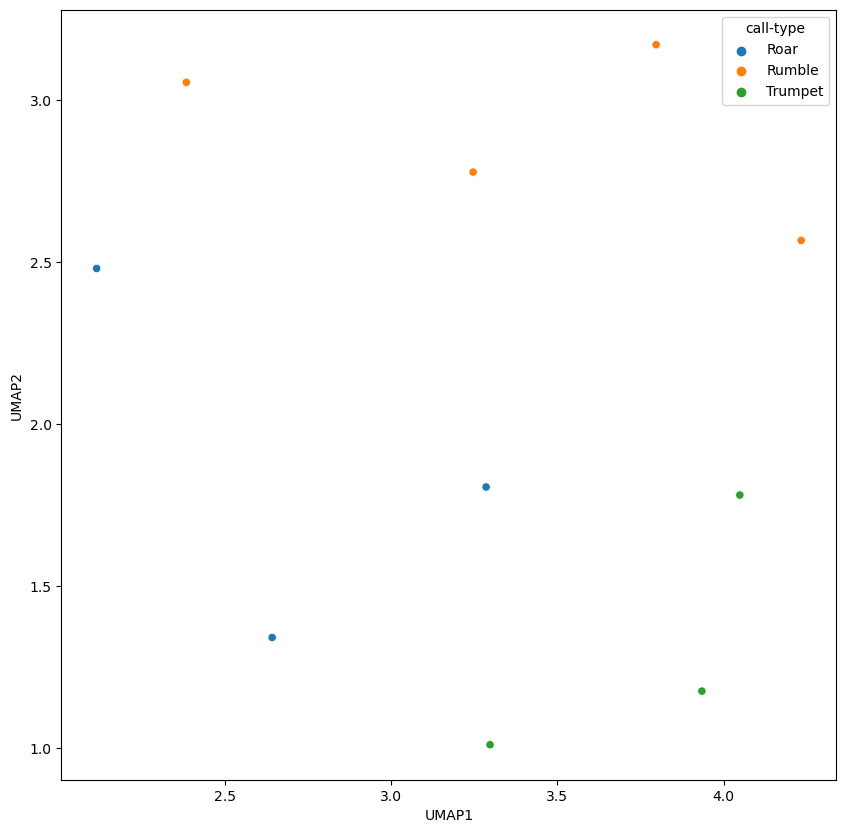

In [8]:
# Carry out the normalisation of the acoustic features and dimensionality reduction 
umap_df = umap_projections(results_df, metadata_df, N_COMP, metric = metric, min_dist = 0)

# Visualise the results to enable observation of clustering
plt.figure(figsize=(10, 10))
sns.scatterplot(x=umap_df['UMAP1'], y=umap_df['UMAP2'], hue=umap_df['call-type']);

### 5. Statistical analysis

We can visually assess the level of separation achieved by the unsupervised methods but this needs to be accompanied by a statistical analysis of its performance. We will do this by calculating the overall silhouette score for the data and the silhouette score per call-type.

The silhouete score is a mathematical representation of the tightness and separation of each cluster (Rousseeuw, 1987). It is calculated as the mean Euclidean distance between data points within a cluster (a) and the mean Euclidean distance to points in the nearest cluster (Rousseeuw, 1987).

Typically, silhouette scores >=0.5 show evidence for clustering, while those >=0.7 show strong evidence for clustering.

In [9]:
# Define data and embeddings 
embeddings = umap_df[['UMAP1', 'UMAP2']].values
labels = umap_df['call-type'].values

# Calculate the overall silhouette score for the whole vocalisation dataset
silhouette_scores_obj = SilhouetteScores(embedding=embeddings, labels=labels)
avrg_score = silhouette_scores_obj.get_avrg_score()
print("Average Silhouette Score:", avrg_score)

# Calculate the silhouette score per call-type
scores_per_class = silhouette_scores_obj.get_score_per_class()
for label, score in zip(silhouette_scores_obj.labeltypes, scores_per_class):
    print("Label:", label, "Silhouette Score:", score)

Average Silhouette Score: 0.1981186
Label: Roar Silhouette Score: -0.005800202488899231
Label: Rumble Silhouette Score: 0.19862161576747894
Label: Trumpet Silhouette Score: 0.4013667106628418


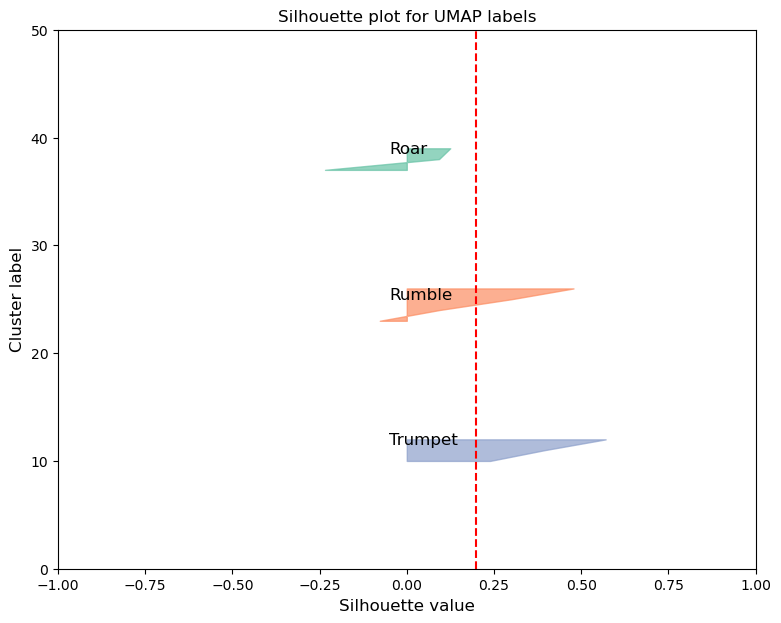

In [10]:
# Plot the silhouette plot
silhouette_scores_obj.plot_sil(embedding_type="UMAP", outname="silhouette_plot.png")